In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt


: 

In [14]:
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/traffic_data2.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['time_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['time_cos'] = np.cos(2 * np.pi * df['hour']/24)

df['current_green_direction'] = df[['density_north', 'density_south', 'density_east', 'density_west']].idxmax(axis=1).str.replace('density_', '')
df['current_green_duration'] = (df[['density_north', 'density_south', 'density_east', 'density_west']].max(axis=1) * 60).astype(int)
df['next_green_direction'] = df['current_green_direction'].shift(-1).fillna('north')
df['next_green_duration'] = df['current_green_duration'].shift(-1).fillna(30)
df = df.iloc[:-1]

direction_map = {'north':0, 'south':1, 'east':2, 'west':3}
df['next_green_encoded'] = df['next_green_direction'].map(direction_map)

duration_max = 60
df['duration_normalized'] = df['next_green_duration'] / duration_max

<ipython-input-15-9a60bf10b5c0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['next_green_encoded'] = df['next_green_direction'].map(direction_map)
<ipython-input-15-9a60bf10b5c0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration_normalized'] = df['next_green_duration'] / duration_max


In [16]:
features = ['time_sin', 'time_cos', 'density_north', 'density_south',
            'density_east', 'density_west', 'current_green_duration']
X = df[features]
y_dir = df['next_green_encoded']
y_dur = df['duration_normalized']

X_train, X_test, y_dir_train, y_dir_test, y_dur_train, y_dur_test = train_test_split(
    X, y_dir, y_dur, test_size=0.2, random_state=42, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [17]:
direction_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_dir_train),
    y=y_dir_train
)
class_weight_dict = dict(enumerate(direction_weights))

sample_weights = np.array([class_weight_dict[cls] for cls in y_dir_train])


In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    X_train_reshaped,
    (y_dir_train, y_dur_train),
    (sample_weights, np.ones_like(y_dur_train))
)).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    X_test_reshaped,
    (y_dir_test, y_dur_test)
)).batch(32).prefetch(tf.data.AUTOTUNE)


In [19]:
inputs = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
x = LSTM(128, return_sequences=True)(inputs)
x = LSTM(64)(x)
direction_out = Dense(4, activation='softmax', name='direction')(x)
duration_out = Dense(1, activation='sigmoid', name='duration')(x)

model = Model(inputs=inputs, outputs=[direction_out, duration_out])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'direction': 'sparse_categorical_crossentropy',
        'duration': 'mse'
    },
    metrics={'direction': ['accuracy']}
)

In [20]:
callbacks = [
    ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_direction_accuracy',
        mode='max'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - direction_accuracy: 0.3337 - direction_loss: 1.4213 - duration_loss: 0.0488 - loss: 1.4700

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - direction_accuracy: 0.3302 - direction_loss: 1.4212 - duration_loss: 0.0493 - loss: 1.4705 - val_direction_accuracy: 0.7569 - val_direction_loss: 1.3647 - val_duration_loss: 0.0301 - val_loss: 1.3948
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - direction_accuracy: 0.6145 - direction_loss: 1.3651 - duration_loss: 0.0356 - loss: 1.4006 - val_direction_accuracy: 0.7569 - val_direction_loss: 1.3441 - val_duration_loss: 0.0206 - val_loss: 1.3647
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - direction_accuracy: 0.8076 - direction_loss: 1.3192 - duration_loss: 0.0216 - loss: 1.3408 - val_direction_accuracy: 0.7188 - val_direction_loss: 1.2950 - val_duration_loss: 0.0102 - val_loss: 1.3052
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - direction_accuracy: 0.8547 - direction_loss: 1.1889 - duration_loss: 0.0079 - loss: 1.1968 - val_direction_accuracy: 0.6667 - val_direction_loss: 1.1851 - val_duration_loss: 0.0027 - val_loss: 1.18

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - direction_accuracy: 0.9117 - direction_loss: 0.4903 - duration_loss: 0.0089 - loss: 0.4992 - val_direction_accuracy: 0.7847 - val_direction_loss: 0.7773 - val_duration_loss: 0.0028 - val_loss: 0.7801
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - direction_accuracy: 0.8848 - direction_loss: 0.2912 - duration_loss: 0.0041 - loss: 0.2952

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - direction_accuracy: 0.8804 - direction_loss: 0.2971 - duration_loss: 0.0041 - loss: 0.3011 - val_direction_accuracy: 0.8090 - val_direction_loss: 0.7442 - val_duration_loss: 0.0026 - val_loss: 0.7468
Epoch 8/100
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - direction_accuracy: 0.9268 - direction_loss: 0.2256 - duration_loss: 0.0036 - loss: 0.2293

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - direction_accuracy: 0.9190 - direction_loss: 0.2431 - duration_loss: 0.0037 - loss: 0.2467 - val_direction_accuracy: 0.8194 - val_direction_loss: 0.6948 - val_duration_loss: 0.0025 - val_loss: 0.6973
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - direction_accuracy: 0.9167 - direction_loss: 0.2147 - duration_loss: 0.0038 - loss: 0.2184 - val_direction_accuracy: 0.8090 - val_direction_loss: 0.6553 - val_duration_loss: 0.0032 - val_loss: 0.6585
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - direction_accuracy: 0.9166 - direction_loss: 0.1943 - duration_loss: 0.0042 - loss: 0.1985 - val_direction_accuracy: 0.8056 - val_direction_loss: 0.6050 - val_duration_loss: 0.0039 - val_loss: 0.6089
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - direction_accuracy: 0.9241 - direction_loss: 0.1782 - duration_loss: 0.0047 - loss: 0.1829 - val_direction_accuracy: 0.7986 - val_direction_loss: 0.5814 - val_duration_loss: 0.0034 - val_loss: 0.584

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - direction_accuracy: 0.9272 - direction_loss: 0.2061 - duration_loss: 0.0021 - loss: 0.2082 - val_direction_accuracy: 0.8229 - val_direction_loss: 0.4111 - val_duration_loss: 0.0019 - val_loss: 0.4130
Epoch 20/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - direction_accuracy: 0.9091 - direction_loss: 0.2291 - duration_loss: 0.0023 - loss: 0.2314 - val_direction_accuracy: 0.4306 - val_direction_loss: 1.7898 - val_duration_loss: 0.0026 - val_loss: 1.7924
Epoch 21/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - direction_accuracy: 0.9046 - direction_loss: 0.2873 - duration_loss: 0.0027 - loss: 0.2900

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - direction_accuracy: 0.9034 - direction_loss: 0.2895 - duration_loss: 0.0027 - loss: 0.2922 - val_direction_accuracy: 0.8333 - val_direction_loss: 0.4017 - val_duration_loss: 0.0029 - val_loss: 0.4046
Epoch 22/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - direction_accuracy: 0.8893 - direction_loss: 0.3732 - duration_loss: 0.0053 - loss: 0.3785 - val_direction_accuracy: 0.4653 - val_direction_loss: 1.2035 - val_duration_loss: 0.0025 - val_loss: 1.2060
Epoch 23/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - direction_accuracy: 0.9471 - direction_loss: 0.1797 - duration_loss: 0.0044 - loss: 0.1841 - val_direction_accuracy: 0.5764 - val_direction_loss: 1.1350 - val_duration_loss: 0.0014 - val_loss: 1.1364
Epoch 24/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - direction_accuracy: 0.9335 - direction_loss: 0.1657 - duration_loss: 0.0017 - loss: 0.1673 - val_direction_accuracy: 0.5486 - val_direction_loss: 1.1337 - val_duration_loss: 0.0016 - val_loss: 1.1

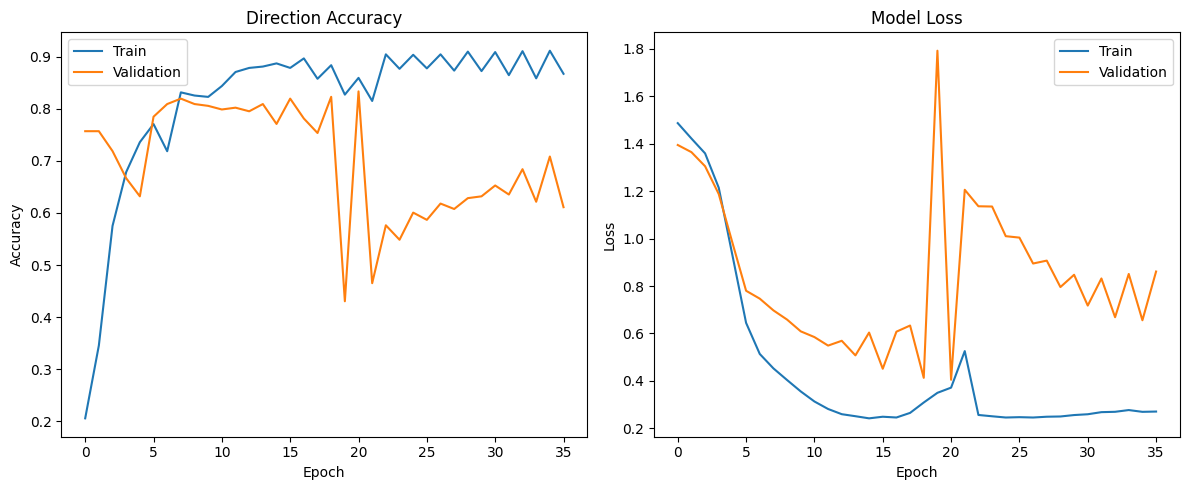

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['direction_accuracy'], label='Train')
plt.plot(history.history['val_direction_accuracy'], label='Validation')
plt.title('Direction Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
def predict_phase(features):
    """Sample prediction function"""
    scaled = scaler.transform([features])
    scaled = scaled.reshape(1, 1, -1)
    dir_probs, dur_norm = model.predict(scaled)
    return {
        'direction': ['north', 'south', 'east', 'west'][np.argmax(dir_probs)],
        'duration': int(np.clip(dur_norm[0][0] * 60, 15, 60))
    }

# Test morning rush hour
print("\nMorning rush prediction:")
print(predict_phase([
    np.sin(2 * np.pi * 8/24),
    np.cos(2 * np.pi * 8/24),
    0.85,  # North density
    0.60,  # South
    0.30,  # East
    0.40,  # West
    45     # Current duration
]))

# Test evening scenario
print("\nEvening prediction:")
print(predict_phase([
    np.sin(2 * np.pi * 18/24),
    np.cos(2 * np.pi * 18/24),
    0.40,
    0.80,
    0.60,
    0.30,
    30
]))


Morning rush prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
{'direction': 'west', 'duration': 36}

Evening prediction:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
{'direction': 'south', 'duration': 39}
